In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as legendre
import resource
import sys

from genquad import *
from testproblems import *
from functionfamiliy import *

In [2]:
resource.setrlimit(resource.RLIMIT_STACK, [0x10000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x100000)

Generate test example

In [3]:
eps_disc = 1e-8
eps_comp = 1e2*eps_disc
eps_quad = 0.1
I = Interval(1e-6,1)
F = example_problem(I, number_of_functions = 10, expr_gen=gen_poly_and_sing)
ex_f, ex_f_expr = F.generate_example_function()
ex_f_expr

-2.59951033953687*x**4 + 0.203716520883713*x**3 - 1.12670196970367*x**2 + 0.150768497042577*x - 0.13243527066841 + 0.446098607520691/x

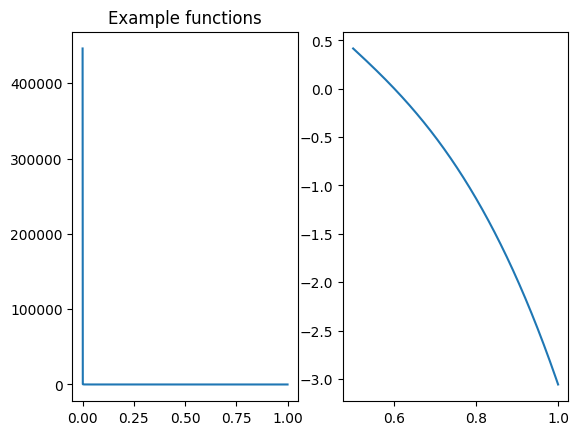

In [4]:
plt.figure("Example function")
xx = np.linspace(I.a,I.b,1000)
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
plt.plot(xx,ex_f(xx))
plt.subplot(1, 2, 2)
xx2 = np.linspace((I.a+I.b)/2,I.b,1000)
plt.plot(xx2,ex_f(xx2))

Discretize and compress

In [5]:
k = 30
x_disc, w_disc, endpoints, intervals = adaptive_discretization(F, eps_disc, k, verbose=False)
U_disc, A, rank, u_list = compress_sequence_of_functions(F, x_disc, w_disc, eps_comp, k, intervals)

Visualise diagonal entry drop off

6


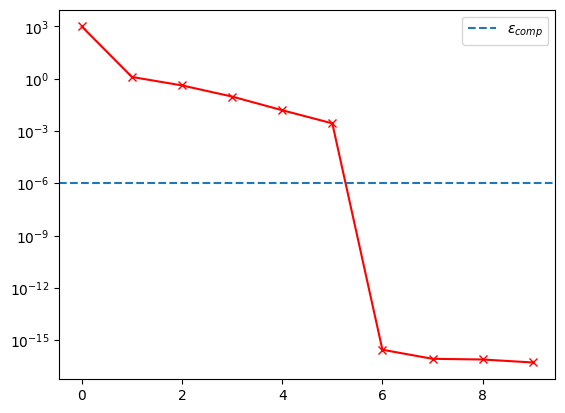

In [24]:
Q,R,perm = sp.linalg.qr(A, pivoting = True)
plt.semilogy(np.abs(np.diag(R)),"-xr");
plt.axhline(eps_comp,linestyle="--",label=r"$\varepsilon_{comp}$")
plt.legend()
print(rank)

Direction visualisation

(1e-06, 1.0)

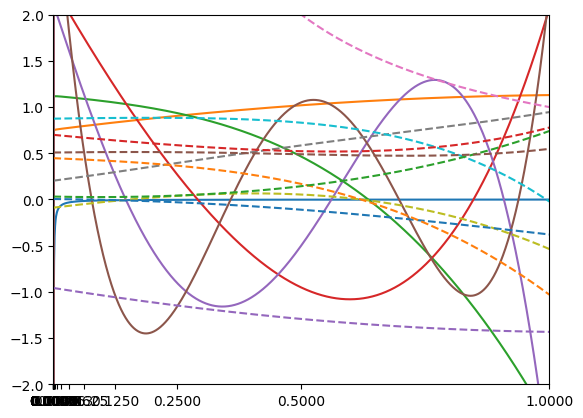

In [7]:
plt.figure();
plt.xticks(endpoints);
xx = np.linspace(I.a,I.b,2000)
for u in u_list:
    plt.plot(xx,u(xx));
for phi in F.functions:
    plt.plot(xx,phi(xx),"--");
plt.ylim(-2,2)
plt.xlim(I.a,I.b)

Chebyshev

In [8]:
x_cheb, w_cheb, idx_cheb = construct_Chevyshev_quadratures(x_disc,w_disc,U_disc)
print(F.target_integral(ex_f_expr), ex_f(x_disc)@w_disc, ex_f(x_cheb)@w_cheb)

5.26148887146234 5.261488871462337 5.261488871462292


Point comparison

Reduce number of points

In [10]:
def rank_remaining_nodes(x, w, U, J):
    n = len(x)
    
    step_directions = list()
    eta = np.zeros(n)
    for k in range(len(x)):
        Jk = J
        Jk[:,k] = 0
        Jk[:,n+k] = 0
        
        delta_r = U[k,:]*w[k] 
        delta_xk,_,_,_ = np.linalg.lstsq(Jk,-delta_r,rcond=None) # Improve by using SMW
        eta[k] = np.linalg.norm(delta_xk)
        step_directions.append(delta_xk)

    idx_sorted = np.argsort(eta)
    eta = sorted(eta)
    
    return idx_sorted, step_directions, eta
        

In [11]:
def dampened_gauss_newton(r, jac, x0, step_size, maxiter = 100, tol = 1e-6):
    x = x0
    for _ in range(maxiter):
        J = jac(x)
        rx = r(x)
        
        # d = np.linalg.solve(-(J.T@J), J.T@rx)
        d,_,_,_ = np.linalg.lstsq(J,rx,rcond = -1)
        x = x - step_size*d
        if np.linalg.norm(d) < tol:
            break
            
    return x

In [40]:
def attempt_to_remove_node(x, w, jacobian, residual, eps_quad):
    n = len(x)
    step_size = 0.2

    idx_sorted = np.arange(len(x))
    for k in idx_sorted:
        mask = np.full(n, True)
        mask[k] = False
        y0 = np.concatenate([x[mask],w[mask]])
        
        y = dampened_gauss_newton(residual, jacobian, y0, step_size)
        eps = np.linalg.norm(residual(y))**2
        
        if eps < eps_quad**2:
            x,w = np.split(y,2)
            return x, w, True
           
    return x, w, False
        

In [41]:
def point_reduction(x_cheb, w_cheb, r, u_list, eps_quad):
    r = U_disc.T@w_disc
    x = x_cheb
    w = w_cheb
    du_list = [u.deriv() for u in u_list]
    improvement_found = True
    
    def jacobian(y):
        x,w = np.split(y,2)
        U = np.column_stack([u(x) for u in u_list])
        dU = np.column_stack([du(x) for du in du_list])
        J = np.hstack([dU.T*w, U.T])
        return J
    
    def residual(y):
        x,w = np.split(y,2)
        U = np.column_stack([u(x) for u in u_list])
        return U.T@w - r

    while improvement_found:
        x, w, improvement_found = attempt_to_remove_node(x, w, jacobian, residual, eps_quad)

    return x, w

In [42]:
# Implement damped gauss newton with Wolfe condition.
eps_quad = 0.3
r = U_disc.T@w_disc
x,w = point_reduction(x_cheb, w_cheb, r, u_list, eps_quad)
print("Quadrature length: ", len(x))

Quadrature length:  3


[0.034 0.169 0.381 0.619 0.831 0.966]
[0.    0.08  0.31  0.599 0.82  0.98 ]
[0.01  0.847 0.362]
Absolute integral error:  1.68974378125242e-5


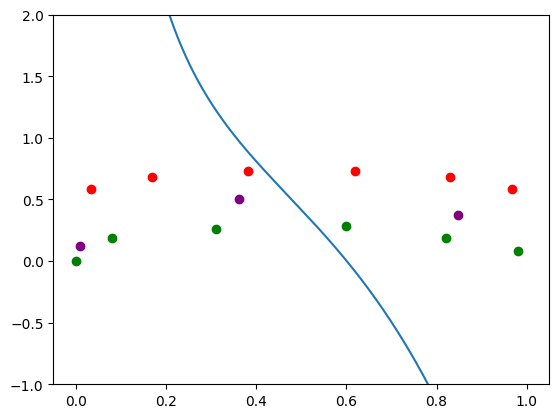

In [52]:
plt.figure()
plt.plot(xx, ex_f(xx))
plt.ylim(-1,2)
plt.scatter(x_cheb, w_cheb, c = 'green',)
x_gl,w_gl = I.translate(np.polynomial.legendre.leggauss(rank))
plt.scatter(x_gl, w_gl, c = 'red',)
plt.scatter(x, w, c = 'purple',)
print(np.around(x_gl,3))
print(np.around(sorted(x_cheb),3))
print(np.around(x,3))

print("Absolute integral error: ", abs(F.target_integral(ex_f_expr) - ex_f(x)@w))